# Packages

In [8]:
from covid19_DTM.models.utils import output_to_visuals
from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
from covid19_DTM.visualization.output import _apply_tick_locator 
from covid19_DTM.models.QALY import lost_QALYs
from covid19_DTM.models.QALY import life_table_QALY_model
life_table = life_table_QALY_model()
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import font_manager
import os
import multiprocessing as mp

# Define simulation settings

In [2]:
# Number of simulations
N=10
# Number of neg. binomial draws/ simulation
K=10
# Number of cpu's
processes=int(mp.cpu_count()/2)
# Number of age groups
age_stratification_size=10
# End of simulation
end_sim='2021-07-01'
# Confidence level used to visualise model fit
conf_int=0.05

# Initialize the model

In [3]:
model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, start_date='2020-03-15')

warmup = float(BASE_samples_dict['warmup'])
dispersion = float(BASE_samples_dict['dispersion'])
start_sim = BASE_samples_dict['start_calibration']

# Perform simulations

In [4]:
from covid19_DTM.models.draw_functions import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_function
out_sim = model.sim([start_sim,end_sim], warmup=warmup, processes=processes, N=N, samples=BASE_samples_dict, draw_function=draw_function)

# QALY calculations

In [5]:
out_AD = lost_QALYs(out_sim,AD_non_hospitalised=True)
out_no_AD = lost_QALYs(out_sim,AD_non_hospitalised=False)

# Visualisations

In [28]:
abs_dir = os.getcwd()
result_folder = '../../results/covid19_DTM/analysis/QALY/long_COVID'

label_font = font_manager.FontProperties(family='CMU Sans Serif',
                                   style='normal', 
                                   size=10)
legend_font = font_manager.FontProperties(family='CMU Sans Serif',
                                   style='normal', 
                                   size=8)

# Verify that the paths exist and if not, generate them
if not os.path.exists(os.path.join(abs_dir,result_folder)):
    os.makedirs(os.path.join(abs_dir,result_folder))

states = ['QALY_D','QALY_NH', 'QALY_C', 'QALY_ICU']
titles = ['Deaths','Non-hospitalised', 'Cohort', 'ICU']
QALYs = {'Non-hospitalised (no AD)':'QALY_NH','Non-hospitalised (AD)':'QALY_NH','Cohort':'QALY_C','ICU':'QALY_ICU','Deaths':'QALY_D'}

colors = ['black','green','orange','red']
palette = cm.get_cmap('tab10').colors
palette_colors = {'black':palette[7],'green':palette[2],'orange':palette[1],'red':palette[3]}

age_groups = out_AD.coords['age_groups'].values
age_group_labels = ['0-12','12-18','18-25','25-35','35-45','45-55','55-65','65-75','75-85','85+']

In [44]:
import pandas as pd
index = pd.Index(age_group_labels+['Total'])
columns = ['Non-hospitalised (no AD)', 'Non-hospitalised (AD)', 'Cohort', 'ICU', 'Deaths','Total (no AD)', 'Total (AD)']
QALY_table_mean = pd.DataFrame(index=index,columns=columns)
QALY_table = pd.DataFrame(index=index,columns=columns)

# QALY per age group per hospitalisation group
for age_group,age_group_label in zip(age_groups,age_group_labels):
    for column in ['Non-hospitalised (no AD)', 'Non-hospitalised (AD)', 'Cohort', 'ICU', 'Deaths']:
        if column == 'Non-hospitalised (AD)':
            out = out_AD
        else:
            out = out_no_AD

        out_slice = out[QALYs[column]].sel({'age_groups':age_group}).sum('doses')[slice(None),-1].values
        mean = out_slice.mean()
        sd = np.std(out_slice)
        lower = np.quantile(out_slice,0.025)
        upper = np.quantile(out_slice,0.975)

        QALY_table_mean[column][age_group_label]=mean
        QALY_table[column][age_group_label] = f'{mean:.0f} ({sd:.0f})'
        
# Total QALY per hospitalisation group        
for column in ['Non-hospitalised (no AD)', 'Non-hospitalised (AD)', 'Cohort', 'ICU', 'Deaths']:
    if column == 'Non-hospitalised (AD)':
        out = out_AD
    else:
        out = out_no_AD
    
    out_slice = out[QALYs[column]].sum('age_groups').sum('doses')[slice(None),-1].values
    mean = out_slice.mean()
    sd = np.std(out_slice)
    lower = np.quantile(out_slice,0.025)
    upper = np.quantile(out_slice,0.975)

    QALY_table_mean[column]['Total']=mean
    QALY_table[column]['Total'] = f'{mean:.0f} ({sd:.0f})'

# Total QALY per age group
for total_label,out in zip(['Total (no AD)', 'Total (AD)'],[out_no_AD,out_AD]):
    total = np.zeros(out.dims['draws'])
    for age_group,age_group_label in zip(age_groups,age_group_labels):
        total_per_age_group = np.zeros(out.dims['draws'])
        for state in states:
            total_per_age_group+=out[state].sel({'age_groups':age_group}).sum('doses')[slice(None),-1].values
        total += total_per_age_group

        mean = total_per_age_group.mean()
        sd = np.std(total_per_age_group)
        lower = np.quantile(total_per_age_group,0.025)
        upper = np.quantile(total_per_age_group,0.975)

        QALY_table_mean[total_label][age_group_label]=mean
        QALY_table[total_label][age_group_label] = f'{mean:.0f} ({sd:.0f})'
    
    mean = total.mean()
    sd = np.std(total)
    lower = np.quantile(total,0.025)
    upper = np.quantile(total,0.975)
    
    QALY_table_mean[total_label]['Total']=mean
    QALY_table[total_label]['Total'] = f'{mean:.0f} ({sd:.0f})'
QALY_table.to_csv(os.path.join(abs_dir,result_folder,'QALY_table.csv'))

In [40]:
test = 'abc\ndfg'
print(test)

abc
dfg


In [27]:
age_groups

['0-12',
 '12-18',
 '18-25',
 '25-35',
 '35-45',
 '45-55',
 '55-65',
 '65-75',
 '75-85',
 '85+']

In [42]:
QALY_table

,Non-hospitalised (no AD),Non-hospitalised (AD),Cohort,ICU,Deaths,Total (no AD),Total (AD)
0-12,6536\n(340),80919\n(30971),1859\n(725),72\n(27),0\n(0),8467\n(863),82842\n(31018)
12-18,3782\n(195),40730\n(15460),852\n(333),158\n(52),276\n(79),5068\n(430),42017\n(15463)
18-25,3231\n(170),31227\n(11735),977\n(380),161\n(56),0\n(0),4369\n(446),32364\n(11762)
25-35,5411\n(289),45341\n(16858),2407\n(931),341\n(124),1691\n(252),9851\n(1029),49782\n(16918)
35-45,7218\n(375),50649\n(18492),2993\n(1153),687\n(224),3534\n(413),14432\n(1266),57876\n(18676)
45-55,6962\n(367),40093\n(14242),4435\n(1681),1400\n(463),8874\n(1326),21671\n(2352),54826\n(14324)
55-65,4377\n(229),20204\n(6883),4071\n(1499),1734\n(550),16167\n(1136),26349\n(2013),42226\n(7338)
65-75,1466\n(78),5149\n(1641),4584\n(1617),2259\n(695),34484\n(2063),42794\n(2764),46536\n(3243)
75-85,311\n(18),770\n(217),3236\n(1070),1009\n(297),39842\n(2001),44398\n(2138),44873\n(2279)
85+,153\n(9),250\n(56),1034\n(291),72\n(23),14558\n(759),15817\n(803),15913\n(757)


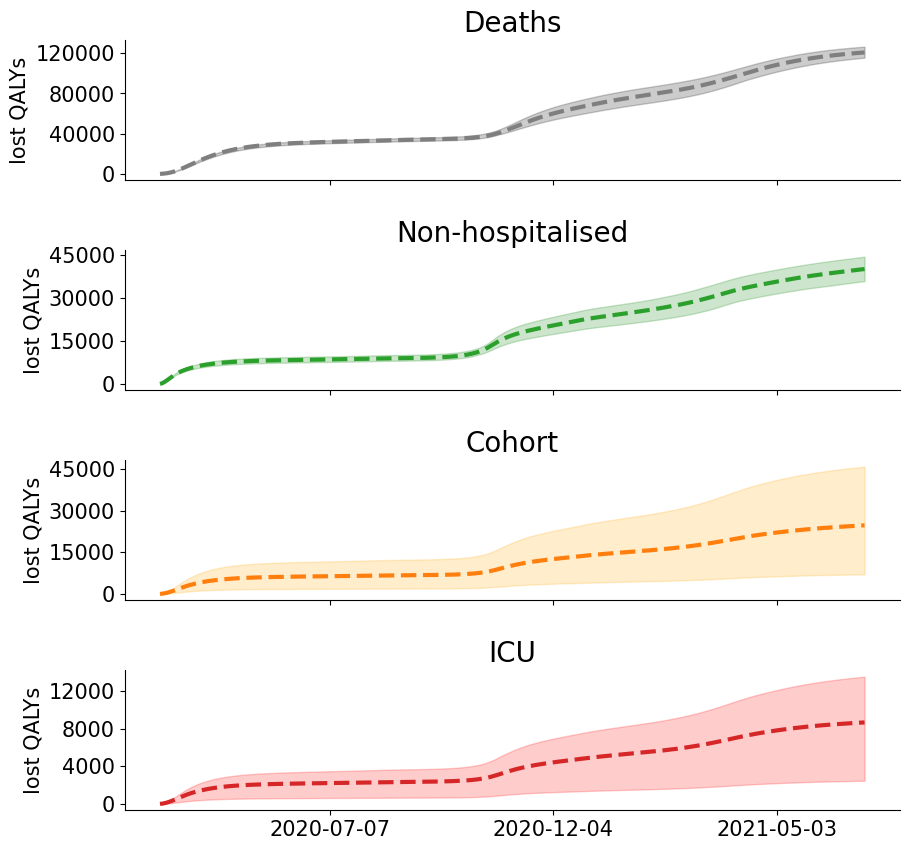

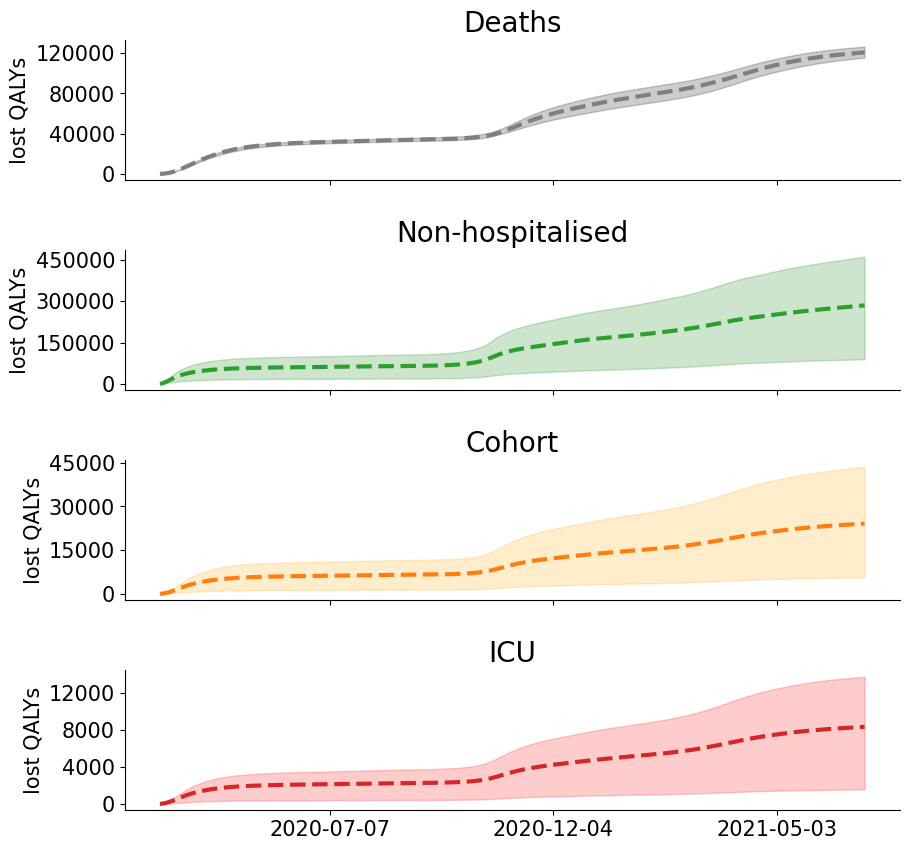

In [ ]:
for scenario,out in zip(['no_AD','AD'],[out_no_AD,out_AD]):
    simtime = out['date'].values

    fig,axs = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(10,10))
    axs=axs.reshape(-1)
    for ax, QALYs, title, color in zip(axs, states,titles,colors):

        mean = out[QALYs].sum('doses').sum('age_groups').mean('draws')
        lower = np.quantile(out[QALYs].sum('doses').sum('age_groups'),0.025,axis=0)
        upper = np.quantile(out[QALYs].sum('doses').sum('age_groups'),0.975,axis=0)

        ax.plot(simtime,mean,'--', color=palette_colors[color])
        ax.fill_between(simtime, lower, upper,alpha=0.20, color = color)

        ax = _apply_tick_locator(ax)
        ax.set_title(title,fontsize=20)
        ax.set_ylabel('lost QALYs')
        ax.grid(False)

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    #fig.savefig(os.path.join(abs_dir,result_folder,f'QALY_losses_{scenario}.png'))

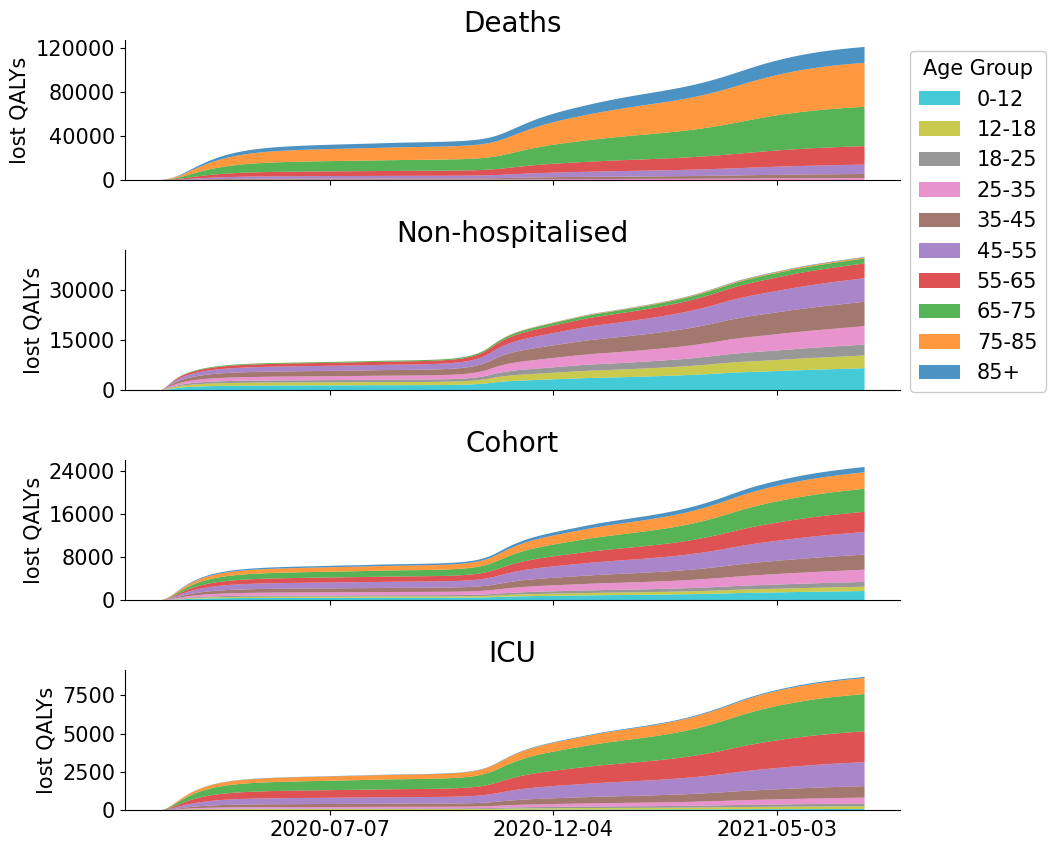

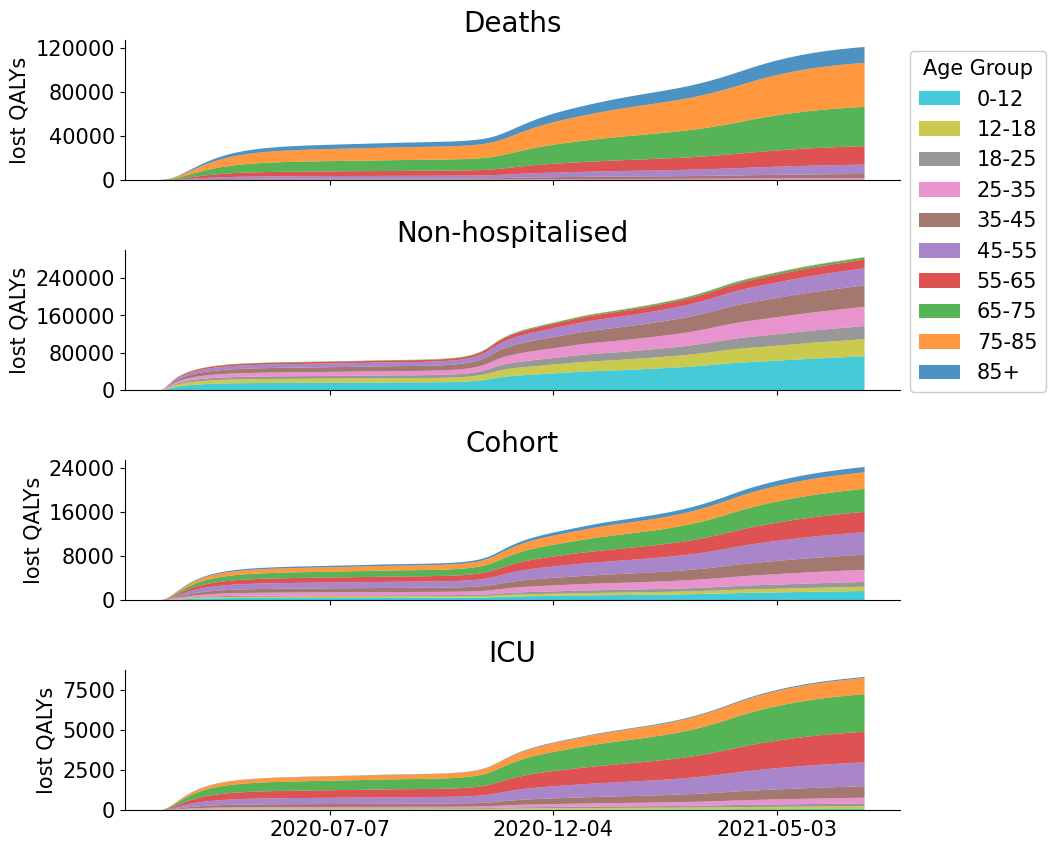

In [ ]:
for scenario,out in zip(['no_AD','AD'],[out_no_AD,out_AD]):    
# QALYS per age group
    Palette=cm.get_cmap('tab10_r', initN.size).colors
    age_group=['0-12','12-18','18-25','25-35','35-45','45-55','55-65','65-75','75-85','85+']

    fig, axs = plt.subplots(4,figsize=(10,10),sharex=True)
    axs=axs.reshape(-1)
    for ax, QALYs, title, color in zip(axs,states,titles,colors):
        ax.stackplot(simtime,np.transpose(out[QALYs].mean(dim="draws").sum(dim='doses').values),linewidth=3, labels=age_group, colors=Palette, alpha=0.8)
        ax.set_title(title,fontsize=20)
        ax.set_ylabel('lost QALYs')
        ax = _apply_tick_locator(ax) 
        ax.grid(False)
    axs[0].legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group', loc="upper left", bbox_to_anchor=(1,1)) 

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    #fig.savefig(os.path.join(abs_dir,result_folder,f'QALY_losses_per_age_group_{scenario}.png'), dpi=600)

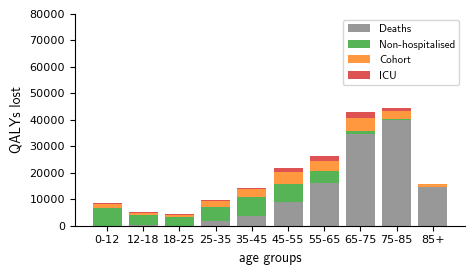

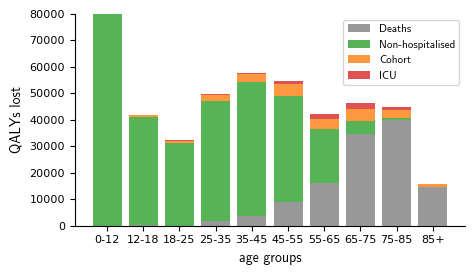

In [31]:
for scenario,out in zip(['no_AD','AD'],[out_no_AD,out_AD]):
    #age_groups=['0-12','12-18','18-25','25-35','35-45','45-55','55-65','65-75','75-85','85+']
    bottom = np.zeros(len(age_groups))
    fig, ax = plt.subplots(figsize=(5,3))
    for state, color, label in zip(states,colors,titles):

        y = out[state].mean('draws').sum('doses')[-1].values
        ax.bar(age_group_labels,y,color=palette_colors[color], alpha=0.8,bottom=bottom,label=label)
        ax.grid(False)
        bottom += y

    ax.legend(prop=legend_font) 
    ax.set_ylabel('QALYs lost',font=label_font)
    ax.set_xlabel('age groups',font=label_font)
    ax.set_ylim([0,80000])
    ax.tick_params(axis='both', which='major', labelsize=8)
    fig.tight_layout()
    fig.savefig(os.path.join(abs_dir,result_folder,f'QALY_losses_per_age_group_{scenario}.png'), dpi=600,bbox_inches='tight')

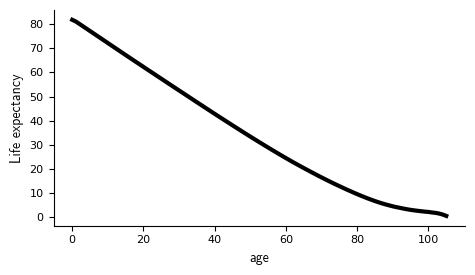

In [25]:
LE = life_table.life_expectancy()
fig,ax = plt.subplots(figsize=(5,3))
ax.plot(LE,'black')
ax.grid(False)
ax.set_ylabel('Life expectancy',font=label_font)
ax.set_xlabel('age',font=label_font)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(os.getcwd(),'../../results/covid19_DTM/preprocessing/QALY_model/long_COVID/','LE.png'),dpi=600,bbox_inches='tight')

In [ ]:
from matplotlib import font_manager

In [ ]:
font_manager.get_font_names()

AttributeError: module 'matplotlib.font_manager' has no attribute 'get_font_names'